# BeamNGpy multishot camera

This example shows how to change the properties of the camera sensor to render images from multiple perspective to emulate a multishot camera.

## Setup

This example will spawn a vehicle on the smallgrid map and have the camera take an image from the front and vary the position of the camera both horizontally and vertically, always pointing at the vehicle's center.

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt  # for later visualization
import numpy as np  # for easier vector computations

from beamngpy import BeamNGpy, Scenario, Vehicle
from beamngpy.sensors import Camera

beamng = BeamNGpy('localhost', 64256)

# Create a vehicle with a camera sensor attached to it
vehicle = Vehicle('ego_vehicle', model='etki', licence='PYTHON', color='Green')
cam_pos = np.array([0, 0, 0])  # placeholder values that will be recomputed later
cam_dir = np.array([0, 0, 0])  # placeholder values that will be recomputed later
cam_fov = 70
cam_res = (512, 512)
camera = Camera(cam_pos, cam_dir, cam_fov, cam_res, colour=True)
vehicle.attach_sensor('camera', camera)

# Simple scenario with the vehicle we just created standing at the origin
car_pos = np.array([0, 0, 0])
scenario = Scenario('smallgrid', 'multishot', description='Demo of the camera sensor used like a multishot camera')
scenario.add_vehicle(vehicle, pos=car_pos, rot=(0, 0, 0))
scenario.make(beamng)

## Running

Once BeamNG.drive has been started and the scenario loaded, we will pivot the camera around the vehicle on the horizontal and vertical axis by -15, 0, +15 degrees each, leading to 9 images in total.

In [2]:
variations = [np.radians(a) for a in [-10, 0, 10]]

def get_bbox_center(bbox):
    rbl = np.array(bbox['rear_bottom_left'])
    fbr = np.array(bbox['front_bottom_right'])
    rtl = np.array(bbox['rear_top_left'])
    center = rbl + ((fbr - rbl) / 2) + ((rtl - rbl) / 2)
    return center

def rotate(vec, h, v):
    rot_x = np.cos(h) * vec[0] - np.sin(h) * vec[1]
    rot_y = np.sin(h) * vec[0] + np.cos(h) * vec[1]
    rot_z = np.sin(v) * rot_y + np.cos(v) * vec[2]
    return np.array([rot_x, rot_y, rot_z])


with beamng as bng:
    bng.load_scenario(scenario)
    bng.start_scenario()
    bng.pause()
    
    center = get_bbox_center(vehicle.get_bbox())
    center[1] -= 0.75  # move center back a bit to get more of the vehicle
    cam_off = center + np.array([3.5, 0, 0])  # Offset the camera 4 meters in front of the center
    
    images = []
    for h in variations:
        image_row = []
        for v in variations:
            current_pos = rotate(cam_off, h, v)
            current_dir = center - current_pos
            
            camera.pos = current_pos
            camera.direction = current_dir
            
            image = bng.poll_sensors(vehicle)['camera']['colour']
            image_row.append(image)
            
        images.append(image_row)

## Plotting

With images collected, we will now set up a simple 3x3 plot to show the 9 angle variations.

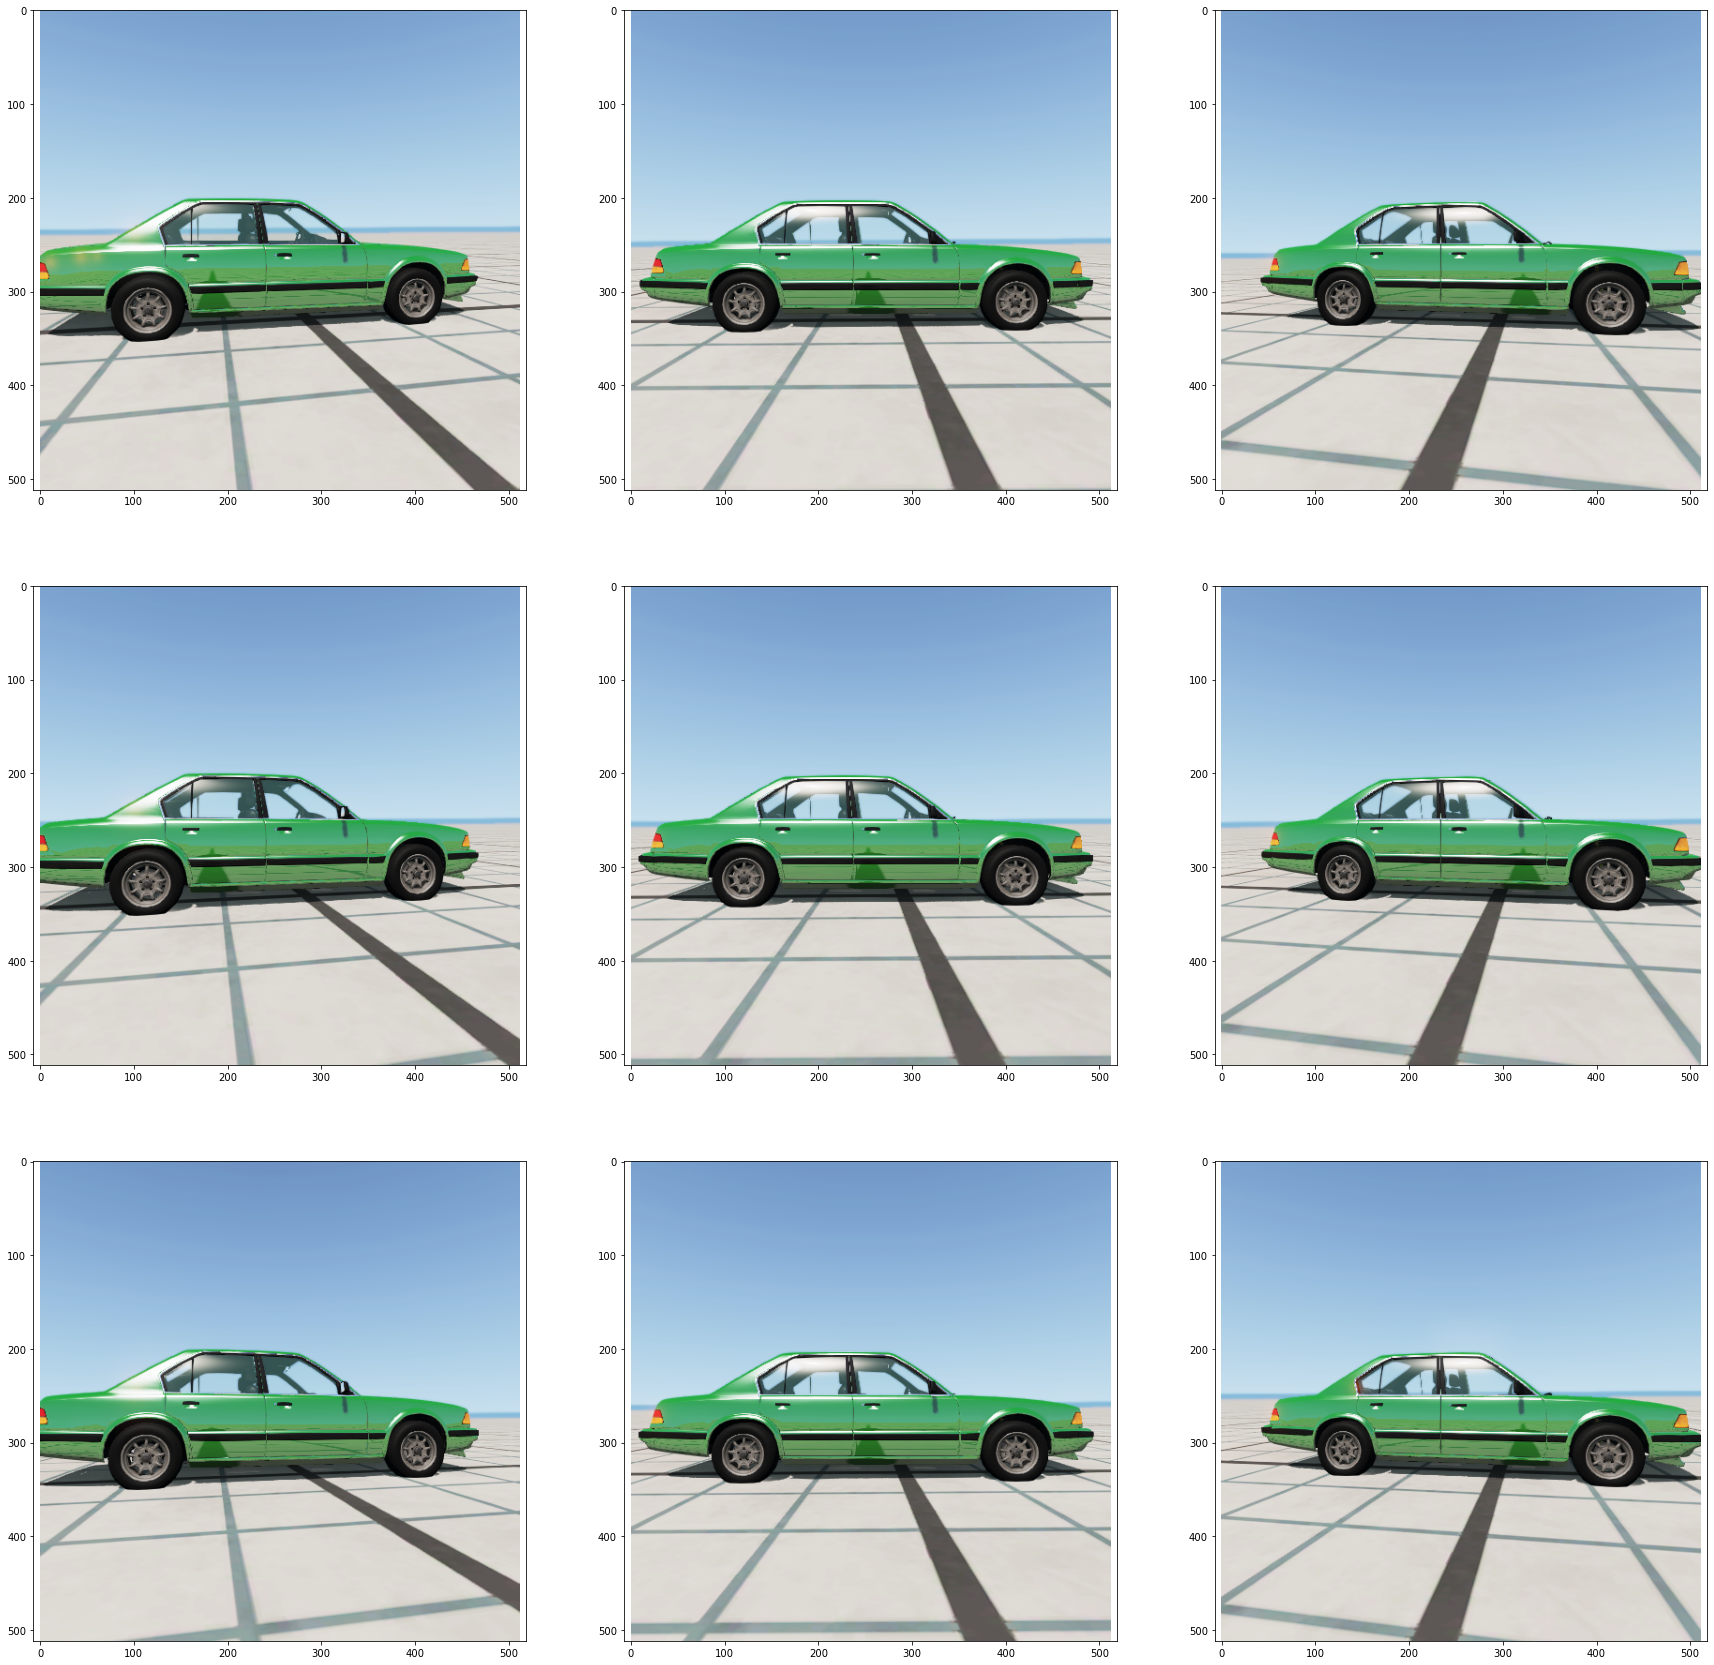

In [3]:
fig, ax = plt.subplots(3, 3, figsize=(30, 30))
for x, row in enumerate(images):
    for y, image in enumerate(row):
        ax[y, x].imshow(np.asarray(image.convert('RGB')))
        ax[y, x].set_aspect('equal', 'datalim')
plt.show()